In [1]:
import numpy as np
from scipy import stats
import pandas as pd
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
# Read in dataset 
data = load_iris()
df = pd.DataFrame(data['data'], columns = data['feature_names'])
df['target'] = data['target']

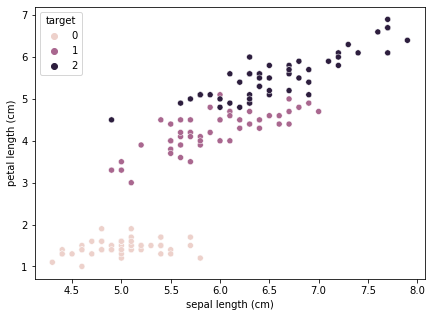

In [3]:
# Plot the data
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x='sepal length (cm)', y='petal length (cm)',hue='target')
plt.show()

From the above diagram, although we are only visualizing 2 dimensions of the 4 dimensional dataset, we can see that the classes are quite distinctly separated, which should make a good case for the KNN algorithm.

In [4]:
# Train test split
def train_test_split(X, y, test_size=0.1):
    ix = list(range(len(X)))
    n_test = round(len(X)*0.1)
    test_ix = random.choices(ix, k=n_test)
    train_ix = [i for i in ix if i not in test_ix]
    
    X_train = X.iloc[train_ix, :].to_numpy()
    X_test = X.iloc[test_ix, :].to_numpy()
    y_train = y.iloc[train_ix].to_numpy()
    y_test = y.iloc[test_ix].to_numpy()
    
    return X_train, X_test, y_train, y_test

In [5]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

### Euclidean distance
The whole idea behind the KNN algorithm is to figure out the distances between the predicting datapoint and the rest of the points, and based on the nearest points determine the class of the datapoint. Euclidean distance is a commonly used measure for the distance between 2 vectors. Other common measures of distance include Manhattan distance and Hamming distance (for binary one-hot-encoded vectors).

In [6]:
def euclidean_distance(p, q):
    return np.sqrt(np.sum(((p-q)**2), axis=1))

In [7]:
# Function to find the top n nearest neighbors' index & distance for each sample
def knn(X, X_train, n=5):
    nearest_neigh_ix = []
    nearest_neigh_dist = []
    distance = [euclidean_distance(x, X_train) for x in X]
    
    for point_dist in distance:
        # use enumerate to get the indices of the nearest points
        sorted_neigh = sorted(enumerate(point_dist), key=lambda x: x[1])[:n]
        ix = [tup[0] for tup in sorted_neigh]
        dist = [tup[1] for tup in sorted_neigh]
        nearest_neigh_ix.append(ix)
        nearest_neigh_dist.append(dist)
        
    return nearest_neigh_ix, nearest_neigh_dist

To predict the target labels of the input data, the simplest method is to just find the target label with the most occurences (i.e. mode) in our neighboring points. In this way, we give equal weights to the n nearest points, how close they are from the point which we are trying to predict does not matter.

In [10]:
def predict(X, X_train, y_train, n=5, weight='equal'):
    nearest_neigh_ix, nearest_neigh_dist = knn(X, X_train, n=n)
    # map the nearest neighbors indices to the dependent variable, i.e. the target
    neigh_targets = [y_train[ix] for ix in nearest_neigh_ix]
    if weight == 'equal':
        y_pred = [stats.mode(target)[0][0] for target in neigh_targets]
        return y_pred
    elif weight == 'distance':
        y_pred = []
        for target, dist in zip(neigh_targets, nearest_neigh_dist):
            tmp = {} # a tempory dict to store the sum of inverse distance per target 
            for target_, dist_ in zip(target, dist):
                if not target_ in tmp:
                    tmp[target_] = 1/dist_
                else:
                    tmp[target_] += 1/dist_
            y_pred.append(max(tmp, key=tmp.get)) # the target with the max inv. distance from the point is the predicted target 
        return y_pred
            
            
def accuracy(y_pred, y_test):
    score = np.sum(y_pred == y_test)/len(y_pred)
    return score

## Test

In [13]:
y_pred = predict(X_test, X_train, y_train, n=5, weight='equal')

accuracy = accuracy(y_pred, y_test)
print(f'The accuracy is {accuracy * 100}%')

The accuracy is 100.0%
